In [11]:
import os

import matplotlib.pyplot as plt
import numpy as np

In [2]:
WORK_DIR = os.getenv("WORK", "")

In [3]:
cov_path = os.path.join(
    WORK_DIR,
    "vision_datasets",
    "computed_stats",
    "edm_imagenet64_all",
    "english_springer_covariance.npy",
)
print(cov_path)

/stor/work/AMDG_Gilpin_Summer2024/vision_datasets/computed_stats/edm_imagenet64_all/english_springer_covariance.npy


In [4]:
cov = np.load(cov_path)
print(cov.shape)

(12288, 12288)


In [114]:
from scipy.sparse.linalg import eigsh

# Compute k largest eigenvalues and eigenvectors
k = 2000
eigenvalues, eigenvectors = eigsh(cov, k=k, which="LM")  # 'LM' = largest magnitude

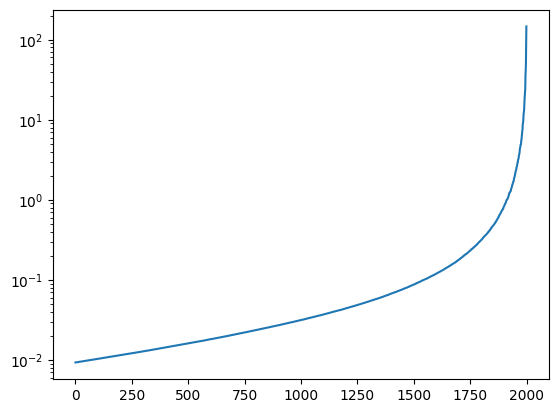

In [115]:
plt.plot(eigenvalues)
plt.yscale("log")

Text(0.5, 0, 'Eigenvalue ($\\lambda^{{{0.1}}}$)')

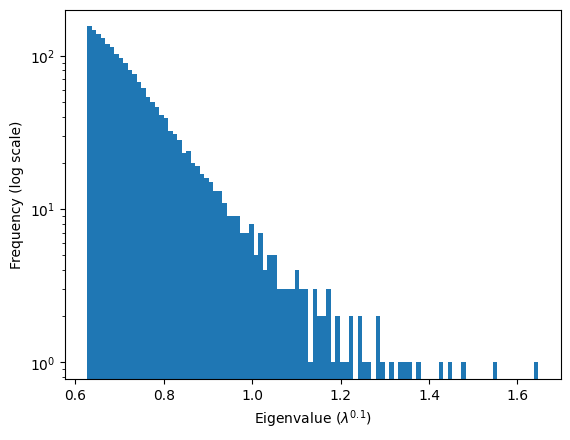

In [116]:
plt.hist(eigenvalues**0.1, bins=100)
plt.yscale("log")
plt.ylabel("Frequency (log scale)")
plt.xlabel(r"Eigenvalue ($\lambda^{{{0.1}}}$)")

In [23]:
eigenvectors.shape

(12288, 1000)

In [57]:
eigv1 = eigenvectors[:, 0]

In [58]:
eigv1_reshaped = eigv1.reshape(64, 64, 3)
print(eigv1_reshaped.shape)

(64, 64, 3)


In [62]:
def process(samples):
    min_val = samples.min()
    max_val = samples.max()
    samples = ((samples - min_val) / (max_val - min_val)) * 255
    samples = samples.astype(np.uint8)
    return samples

In [60]:
# eigv1_img = eigv1_pil.convert("RGB")
eigv1_img = process(eigv1_reshaped)

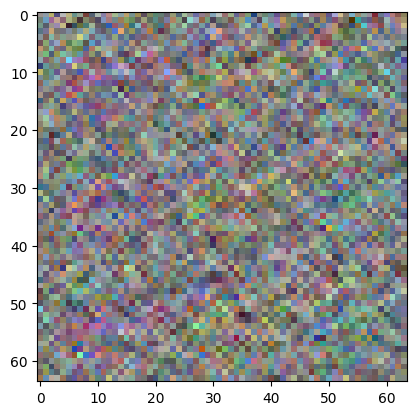

In [64]:
plt.imshow(eigv1_img)

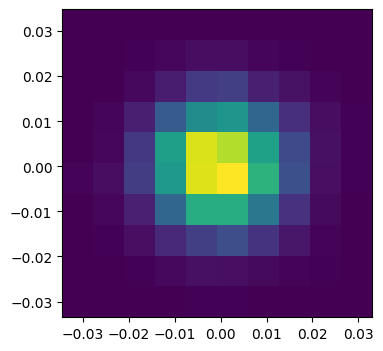

In [70]:
plt.figure(figsize=(4, 4))
plt.hist2d(eigenvectors[:, 8], eigenvectors[:, 10]);

In [6]:
def randomized_svd(A, rank, num_iter=2):
    """
    Perform a randomized SVD on matrix A.

    Args:
        A (np.ndarray): Input matrix of shape (m, n).
        rank (int): Target rank for the approximation.
        num_iter (int): Number of power iterations (improves accuracy).

    Returns:
        U (np.ndarray): Left singular vectors.
        S (np.ndarray): Singular values.
        Vt (np.ndarray): Right singular vectors (transposed).
    """
    # Step 1: Random projection
    m, n = A.shape
    random_matrix = np.random.randn(n, rank)
    Y = A @ random_matrix

    # Step 2: Orthogonalize Y
    Q, _ = np.linalg.qr(Y)

    # Step 3: Project A onto the smaller space
    B = Q.T @ A

    # Step 4: Compute SVD on the smaller matrix
    U_hat, S, Vt = np.linalg.svd(B, full_matrices=False)

    # Step 5: Map U back to the original space
    U = Q @ U_hat
    return U, S, Vt

In [92]:
U, S, Vt = randomized_svd(cov, rank=4000)
print(U.shape, S.shape, Vt.shape)

(12288, 4000) (4000,) (4000, 12288)


In [93]:
U1_processed = process(U[:, 0].reshape(64, 64, 3))
print(U1_processed.shape)

(64, 64, 3)


(-0.5, 63.5, 63.5, -0.5)

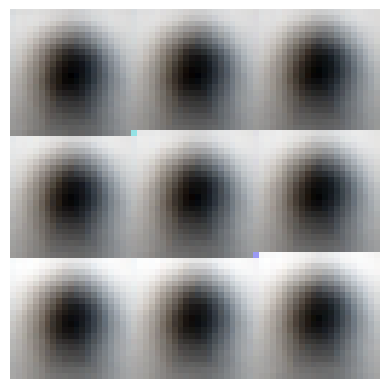

In [94]:
plt.imshow(U1_processed)
plt.axis("off")

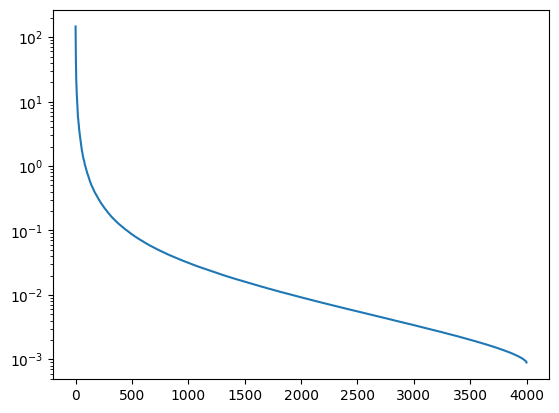

In [95]:
# plot singular values
plt.plot(S)
plt.yscale("log")

In [98]:
S.shape

(4000,)

Text(0.5, 0, 'Eigenvalue')

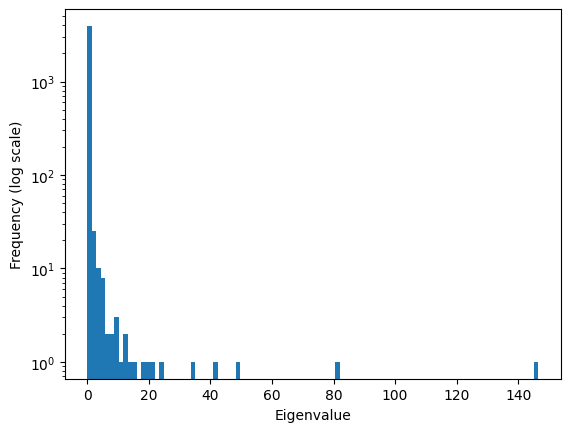

In [113]:
plt.hist(S, bins=100)
plt.yscale("log")
plt.ylabel("Frequency (log scale)")
plt.xlabel("Eigenvalue")

Text(0.5, 0, 'Eigenvalue ($\\lambda^{{{0.1}}}$)')

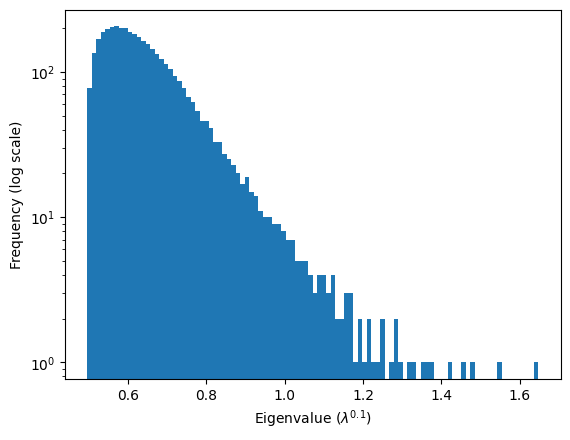

In [102]:
plt.hist(S**0.1, bins=100)
plt.yscale("log")
plt.ylabel("Frequency (log scale)")
plt.xlabel(r"Eigenvalue ($\lambda^{{{0.1}}}$)")

In [103]:
def randomized_svd_improved(A, rank, oversampling=10, n_iter=2):
    """
    Perform a randomized SVD on matrix A.

    Args:
        A (np.ndarray): Input matrix of shape (m, n).
        rank (int): Target rank for the approximation.
        oversampling (int): Oversampling parameter (default 10) to improve accuracy.
        n_iter (int): Number of power iterations (default 2) for numerical stability.

    Returns:
        U (np.ndarray): Approximate left singular vectors of shape (m, rank).
        S (np.ndarray): Approximate singular values of shape (rank,).
        Vt (np.ndarray): Approximate right singular vectors (transposed) of shape (rank, n).
    """
    m, n = A.shape
    target_rank = rank + oversampling

    # Step 1: Random sampling
    random_matrix = np.random.randn(n, target_rank)  # Gaussian random matrix
    Y = A @ random_matrix  # Shape: (m, target_rank)

    # Step 2: Power iteration to enhance approximation (optional for stability)
    for _ in range(n_iter):
        Y = A @ (A.T @ Y)

    # Step 3: Orthonormalization of Y
    Q, _ = np.linalg.qr(Y)  # Shape: (m, target_rank)

    # Step 4: Project A onto the low-dimensional subspace
    B = Q.T @ A  # Shape: (target_rank, n)

    # Step 5: Compute SVD of the smaller matrix B
    U_hat, S, Vt = np.linalg.svd(B, full_matrices=False)

    # Step 6: Map U_hat back to the original space
    U = Q @ U_hat[:, :rank]  # Shape: (m, rank)
    S = S[:rank]  # Shape: (rank,)
    Vt = Vt[:rank, :]  # Shape: (rank, n)

    return U, S, Vt

In [104]:
U, S, Vt = randomized_svd_improved(cov, rank=4000)

In [105]:
print("Reconstructed shape:", (U @ np.diag(S) @ Vt).shape)
print("Singular values:", S)

Reconstructed shape: (12288, 12288)
Singular values: [1.46401649e+02 8.19670640e+01 4.83659150e+01 ... 2.32353060e-04
 2.30779552e-04 2.30329396e-04]


Text(0.5, 0, 'Eigenvalue ($\\lambda^{{{0.1}}}$)')

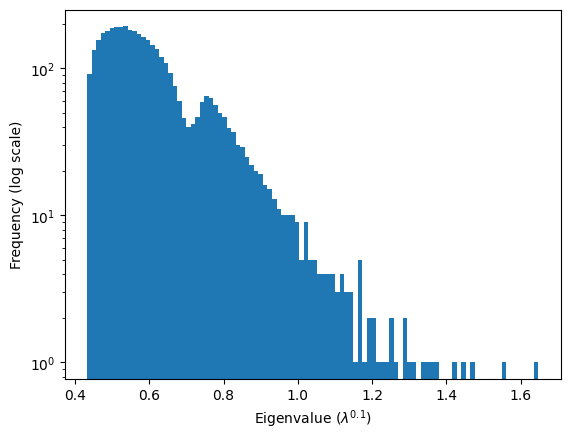

In [108]:
plt.hist(S**0.1, bins=100)
plt.yscale("log")
plt.ylabel("Frequency (log scale)")
plt.xlabel(r"Eigenvalue ($\lambda^{{{0.1}}}$)")